# Transactions...

In [1]:
import pandas as pd
import numpy as np
import holidays

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

From 118K transactions, a minority 875 is flagged.

We have two files, transactions with the 118K transactions of a year (with some features) and labels (the 875 events flagged and their reported time).

In [2]:
df = pd.read_csv("Data/transactions_obf.csv")
aux = pd.read_csv("Data/labels_obf.csv")

We first merge them and create a binary variable of the reported transactions.

In [3]:
df = df.merge(aux, how='left', on=['eventId'])
df['flag'] = np.where(df.reportedTime.notnull(), 1, 0)


We study the average time needed to flag a transaction.

In [4]:
df['transactionTime']= pd.to_datetime(df['transactionTime'])
df['reportedTime']= pd.to_datetime(df['reportedTime'])
df['daysDetection'] = (df['reportedTime'] - df['transactionTime']).dt.total_seconds() / (3600*24)

It takes 9 days and a half on average to flag the transactions.

In [5]:
df['daysDetection'].describe()

count    875.000000
mean       9.473981
std       16.636215
min       -0.032731
25%        1.638721
50%        3.504236
75%        5.635399
max       95.156192
Name: daysDetection, dtype: float64

There is only one negative one, and the reason is due to the lack of preccision in the time of the reported time.

In [6]:
df[df.daysDetection < 0]

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,flag,daysDetection
35988,2017-05-01 00:47:08+00:00,2547545A1,c9882f1c,5d3676,4814,826,RG14,1,51.0,7500,2017-05-01 00:00:00+00:00,1,-0.032731


We are going to create some new features that are going to try to help to predict when a transaction is a fraud.

Regarding time, we can hypothesise that night transactions could be more likely to be fraud, as well as weekend transactions or holiday times.

In [7]:
# Extract hour, month, day of the week
df['hour'] = df['transactionTime'].dt.hour
df['month'] = df['transactionTime'].dt.month
df['year'] = df['transactionTime'].dt.year
df['dayType'] = df['transactionTime'].dt.dayofweek  # Monday=0, Sunday=6

# Create a holiday binary variable
uk_holidays = holidays.UK(years=[2017,2018])  # You can change this to holidays.US(), etc.
df['isHoliday'] = df['transactionTime'].dt.date.isin(uk_holidays)
print(uk_holidays)



{datetime.date(2017, 4, 14): 'Good Friday', datetime.date(2017, 5, 1): 'May Day', datetime.date(2017, 5, 29): 'Spring Bank Holiday', datetime.date(2017, 1, 1): "New Year's Day", datetime.date(2017, 1, 2): "New Year's Day (observed)", datetime.date(2017, 12, 25): 'Christmas Day', datetime.date(2017, 12, 26): 'Boxing Day', datetime.date(2018, 3, 30): 'Good Friday', datetime.date(2018, 5, 7): 'May Day', datetime.date(2018, 5, 28): 'Spring Bank Holiday', datetime.date(2018, 1, 1): "New Year's Day", datetime.date(2018, 12, 25): 'Christmas Day', datetime.date(2018, 12, 26): 'Boxing Day'}


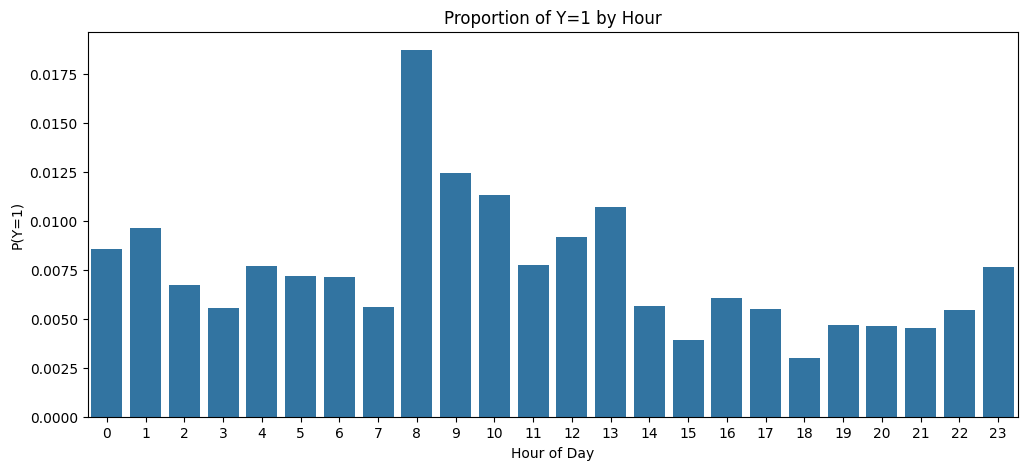

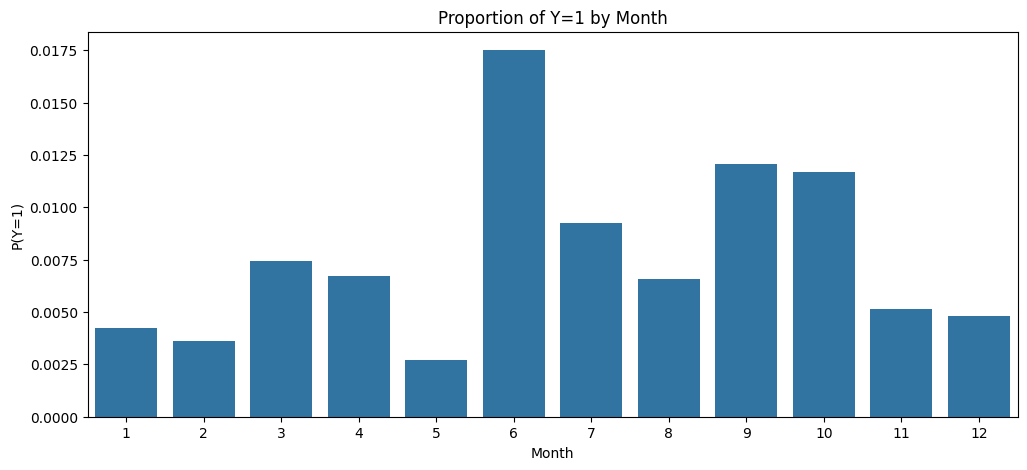

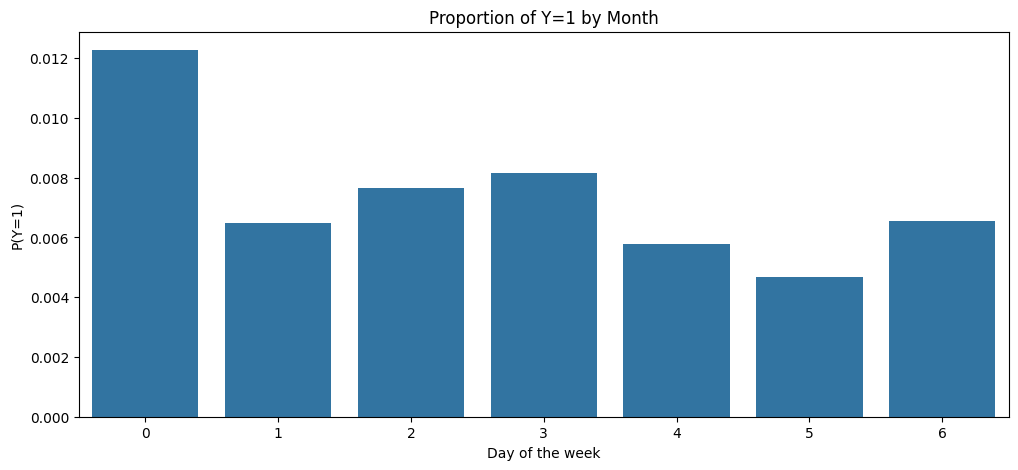

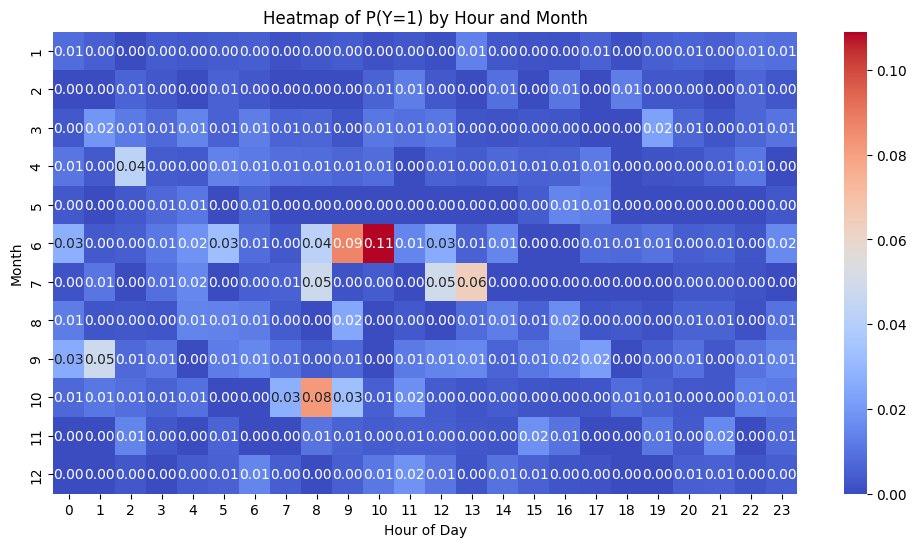

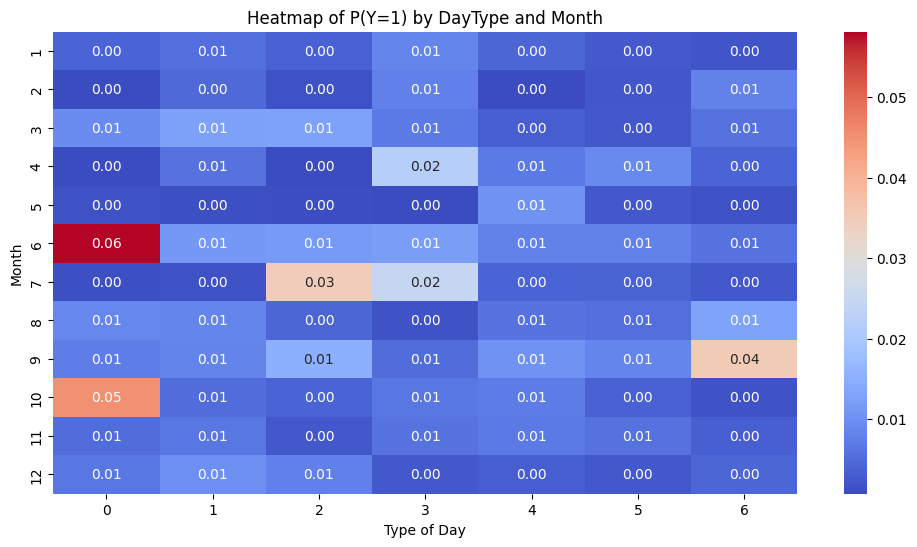

Chi-square test for hour: p-value = 0.0000
Chi-square test for month: p-value = 0.0000
Optimization terminated successfully.
         Current function value: 0.043339
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   flag   No. Observations:               118621
Model:                          Logit   Df Residuals:                   118618
Method:                           MLE   Df Model:                            2
Date:                Fri, 21 Feb 2025   Pseudo R-squ.:                0.005143
Time:                        14:56:48   Log-Likelihood:                -5141.0
converged:                       True   LL-Null:                       -5167.5
Covariance Type:            nonrobust   LLR p-value:                 2.873e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8881

In [8]:
# 1. Aggregation - Compute Proportion of Y = 1 by Hour and Month
hourly_prob = df.groupby('hour')['flag'].mean()
monthly_prob = df.groupby('month')['flag'].mean()
dayType_prob = df.groupby('dayType')['flag'].mean()

# 2. Visualization
plt.figure(figsize=(12, 5))
sns.barplot(x=hourly_prob.index, y=hourly_prob.values)
plt.xlabel("Hour of Day")
plt.ylabel("P(Y=1)")
plt.title("Proportion of Y=1 by Hour")
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=monthly_prob.index, y=monthly_prob.values)
plt.xlabel("Month")
plt.ylabel("P(Y=1)")
plt.title("Proportion of Y=1 by Month")
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=dayType_prob.index, y=dayType_prob.values)
plt.xlabel("Day of the week")
plt.ylabel("P(Y=1)")
plt.title("Proportion of Y=1 by Month")
plt.show()


# 3. Heatmap of Hour vs. Month
heatmap_data = df.pivot_table(values='flag', index='month', columns='hour', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
plt.xlabel("Hour of Day")
plt.ylabel("Month")
plt.title("Heatmap of P(Y=1) by Hour and Month")
plt.show()


heatmap_data2 = df.pivot_table(values='flag', index='month', columns='dayType', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data2, cmap="coolwarm", annot=True, fmt=".2f")
plt.xlabel("Type of Day")
plt.ylabel("Month")
plt.title("Heatmap of P(Y=1) by DayType and Month")
plt.show()

# 4. Chi-Square Test (Check Dependency between Time Variables and Y)
def chi_square_test(feature):
    contingency_table = pd.crosstab(df[feature], df['flag'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {feature}: p-value = {p:.4f}")
    return p

chi_square_test("hour")
chi_square_test("month")

# 5. Logistic Regression Model
# Convert categorical variables into dummy variables
X = pd.get_dummies(df[['hour', 'month']], drop_first=True)
y = df['flag']
X = sm.add_constant(X)  # Add intercept
model = sm.Logit(y, X).fit()
print(model.summary())


In [9]:
vacation_prob = df.groupby('isHoliday')['flag'].mean()
vacation_prob

isHoliday
False    0.007483
True     0.001799
Name: flag, dtype: float64

We have 766 people.

In [10]:
freq = df['accountNumber'].value_counts()
ranking = {cat: rank + 1 for rank, (cat, _) in enumerate(freq.items())}

df['ranking'] = df['accountNumber'].map(ranking)

threshold = 100  
print( (freq > threshold).sum())

302


In [11]:
# Compute quartiles
quartiles = df['ranking'].quantile([0.25, 0.5, 0.75]).values
bins = [df['ranking'].min() - 1] + list(quartiles) + [df['ranking'].max() + 1]

# Discretize using pd.cut()
df['quartileNumberTransactions'] = pd.cut(df['ranking'], bins=bins, labels=['1', '2', '3', '4']).astype(int)

In [12]:
df['transactionAmountRounded'] = df['transactionAmount'].round(2).astype(str)
df['transactionAmountRounded'] = df['transactionAmountRounded'].apply(lambda x: str(x).split('.')[-1]).astype(int)
df['transactionAmountEnds00'] = df['transactionAmountRounded'].apply(lambda x: x == 0)
df['transactionAmountEndsX0'] = df['transactionAmountRounded'].apply(lambda x: x < 10)
df = df.drop(columns=['transactionAmountRounded'])

In [13]:
prob = df.groupby('transactionAmountEnds00')['flag'].mean()
prob

transactionAmountEnds00
False    0.007611
True     0.006643
Name: flag, dtype: float64

In [14]:
# Assign order of transactions within each day, week, and month
df['orderDay'] = df.groupby(['accountNumber', df['transactionTime'].dt.date]).cumcount() + 1
df['orderWeek'] = df.groupby(['accountNumber', df['transactionTime'].dt.to_period('W')]).cumcount() + 1
df['orderMonth'] = df.groupby(['accountNumber', df['transactionTime'].dt.to_period('M')]).cumcount() + 1

/var/folders/8s/3ckbm4gn5tzg2dspgywczq300000gn/T/ipykernel_2822/3459562872.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['orderWeek'] = df.groupby(['accountNumber', df['transactionTime'].dt.to_period('W')]).cumcount() + 1
/var/folders/8s/3ckbm4gn5tzg2dspgywczq300000gn/T/ipykernel_2822/3459562872.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['orderMonth'] = df.groupby(['accountNumber', df['transactionTime'].dt.to_period('M')]).cumcount() + 1


In [15]:
df = df.sort_values(by=['accountNumber', 'transactionTime'])
df = df.reset_index()

In [16]:


# Compute time difference from the previous transaction of the same accountNumber
df['timeDiffHours'] = df.groupby('accountNumber')['transactionTime'].diff().dt.total_seconds() / 3600

# Assign -1 to the first transaction of each account
df['timeDiffHours'] = df['timeDiffHours'].fillna(-1)





In [17]:
def cumulative_sum(df, row_idx, time, column='transactionAmount'):
    end_index = row_idx
    start_index = row_idx
    account = df.loc[row_idx, 'accountNumber']
    end_time = df.loc[row_idx, 'transactionTime']
    while start_index>0:
        if df.loc[start_index-1, 'accountNumber'] != account:
            break
        else:
            if (end_time -df.loc[start_index-1, 'transactionTime']).total_seconds() < time:
                start_index -= 1
            else:
                break
    if start_index == end_index:
        return df.loc[row_idx, column]
    return df.loc[start_index:end_index, column].sum()

df['amountLastHour'] = df.index.to_series().apply(lambda idx: cumulative_sum(df, idx, 3600))
df['amountLastDay'] = df.index.to_series().apply(lambda idx: cumulative_sum(df, idx, 3600*24))
df['amountLastWeek'] = df.index.to_series().apply(lambda idx: cumulative_sum(df, idx, 3600*24*7))
df['amountLastMonth'] = df.index.to_series().apply(lambda idx: cumulative_sum(df, idx, 3600*24*30))

In [18]:
def compute_merchant_risk_score(df):
    """
    Computes a fraud risk score for each merchant based on historical fraud rates.
    
    Parameters:
    df (pd.DataFrame): Transaction data with 'merchantId' and 'flag' columns.
    
    Returns:
    pd.Series: A mapping of merchants to their fraud risk score.
    """
    # Compute fraud rate per merchant
    merchant_fraud_rates = df.groupby('merchantId')['flag'].mean()
    
    # Normalize scores between 0 and 1
    risk_score = (merchant_fraud_rates - merchant_fraud_rates.min()) / (merchant_fraud_rates.max() - merchant_fraud_rates.min())
    
    return risk_score

# Example usage

df['merchantRiskScore'] = df['merchantId'].map(compute_merchant_risk_score(df[df.year == 2017]))

df['merchantRiskScore'] = df['merchantRiskScore'].fillna(1)


In [19]:
def has_transacted_before(df):
    """
    Checks if a customer has transacted with a merchant before.
    
    Parameters:
    df (pd.DataFrame): Transaction data with 'accountNumber' and 'merchantId'.
    
    Returns:
    pd.Series: 1 if the customer has transacted before, 0 otherwise.
    """
    seen = set()
    history = []

    for _, row in df.iterrows():
        key = (row['accountNumber'], row['merchantId'])
        if key in seen:
            history.append(1)  # Has transacted before
        else:
            history.append(0)  # First-time transaction
            seen.add(key)

    return pd.Series(history)


df['frequentMerchant'] = has_transacted_before(df)


In [20]:
def geographic_deviation(df):
    """
    Flags transactions where the merchant country is unusual for the user.
    
    Parameters:
    df (pd.DataFrame): Transaction data with 'accountNumber' and 'merchantCountry'.
    
    Returns:
    pd.Series: 1 if the country is unusual, 0 otherwise.
    """
    user_country_map = df.groupby('accountNumber')['merchantCountry'].agg(lambda x: x.mode()[0])
    return (df['merchantCountry'] != df['accountNumber'].map(user_country_map)).astype(int)


df['geoDeviation'] = geographic_deviation(df)


In [21]:
# NEED TO SOLVE
# Fill missing merchantZip with the previous available Zip for the same merchantId
def fill_merchant_zip(df):
    # Fill NaN with the previous value for the same merchantId
    df['merchantZip'] = df.groupby('merchantId')['merchantZip'].apply(lambda x: x.ffill().bfill())
    return df

# Apply the function
#df = fill_merchant_zip(df)

In [22]:
def merchant_zip_consistency(df, feature = 'merchantZip'):
    """
    Flags if a customer's transaction is in an unusual ZIP code area based on past transactions.
    
    Parameters:
    df (pd.DataFrame): Transaction data with 'accountNumber' and 'merchantZip' columns.
    
    Returns:
    pd.Series: 1 if the transaction is in an unusual ZIP code, 0 otherwise.
    """
    # Find the most frequent ZIP code for each customer
    user_zip_map = df.groupby('accountNumber')['merchantZip'].agg(lambda x: x.mode()[0])
    
    # Compare current transaction ZIP with the most frequent ZIP for that customer
    return (df['merchantZip'] != df['accountNumber'].map(user_zip_map)).astype(int)
df['merchantZip'] = df['merchantZip'].astype(str)
df['merchantZipLetters'] = df['merchantZip'].str.extract('([A-Za-z]+)', expand=False)

df['zipConsistency'] = merchant_zip_consistency(df)
df['areaConsistency'] = merchant_zip_consistency(df, feature = 'merchantZipLetters')



In [23]:
df['avgTransactionAmount'] = df.groupby('accountNumber')['transactionAmount'].transform('mean')

df['transactionRatio'] = df['transactionAmount'] / (df['availableCash']+1)
df['spendingStd'] = df.groupby('accountNumber')['transactionAmount'].transform('std')
df['spendingStd'] = df['spendingStd'].fillna(0)
df['diffFromAvg'] = df['transactionAmount'] - df['avgTransactionAmount']

In [54]:
df['diffStd'] = df.apply(lambda row: row['diffFromAvg'] / row['spendingStd'] if row['spendingStd'] != 0 else 0, axis=1)

In [24]:
def compute_country_risk_score(df):
    """
    Computes a fraud risk score for each country based on historical fraud rates.
    
    Parameters:
    df (pd.DataFrame): Transaction data with 'merchantCountry' and 'isFraud' columns.
    
    Returns:
    pd.Series: A mapping of countries to their fraud risk score.
    """
    country_fraud_rates = df.groupby('merchantCountry')['flag'].mean()
    # Normalize fraud rates to get a risk score between 0 and 1
    risk_score = (country_fraud_rates - country_fraud_rates.min()) / (country_fraud_rates.max() - country_fraud_rates.min())
    return risk_score

# Example usage

df['countryRiskScore'] = df['merchantCountry'].map(compute_country_risk_score(df[df.year == 2017]))
df['countryRiskScore'] = df['countryRiskScore'].fillna(1)


In [25]:
df['transactionDate'] = df['transactionTime'].dt.date

df['sameDayPayment'] = df.groupby(['accountNumber', 'merchantId', 'transactionDate', 'transactionAmount'])['eventId'].transform('count') > 1


In [26]:
prob = df.groupby('sameDayPayment')['flag'].mean()
prob

sameDayPayment
False    0.007078
True     0.025601
Name: flag, dtype: float64

In [27]:
aux = df[df.flag == 1]

In [28]:
aux['transactionAmount'].value_counts()

transactionAmount
2.00      28
0.00      22
11.00     11
9.00      11
99.00     11
          ..
201.80     1
153.89     1
153.91     1
206.66     1
59.98      1
Name: count, Length: 664, dtype: int64

In [29]:
aux[aux.year==2018]['transactionAmount'].value_counts()

transactionAmount
128.25     2
0.94       1
122.25     1
128.30     1
12.47      1
122.21     1
127.72     1
122.22     1
122.32     1
0.00       1
0.65       1
0.56       1
117.99     1
384.06     1
0.52       1
3.72       1
120.76     1
4.11       1
110.45     1
130.74     1
128.58     1
125.00     1
532.00     1
17.21      1
1658.20    1
71.91      1
330.29     1
305.00     1
301.09     1
19.95      1
206.66     1
123.25     1
19.00      1
9.00       1
2.00       1
0.83       1
48.00      1
28.00      1
Name: count, dtype: int64

In [30]:
aux[aux['transactionAmount'] == 128.25]

,index,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,...,merchantZipLetters,zipConsistency,areaConsistency,avgTransactionAmount,transactionRatio,spendingStd,diffFromAvg,countryRiskScore,transactionDate,sameDayPayment
36392,114910,2018-01-18 23:42:34+00:00,50000167A1,4547ba27,e57467,4121,826,EC3V,1,128.25,...,EC,1,1,53.665377,0.012213,170.779825,74.584623,0.003262,2018-01-18,True
36394,114913,2018-01-18 23:50:24+00:00,50011639A1,4547ba27,e57467,4121,826,EC3V,1,128.25,...,EC,1,1,53.665377,0.012213,170.779825,74.584623,0.003262,2018-01-18,True


In [31]:
aux[aux.year==2018]['posEntryMode'].value_counts()

posEntryMode
1     22
81    12
90     4
5      1
Name: count, dtype: int64

In [32]:
df['merchantId'].value_counts()

merchantId
96878e    3294
243074    2281
7f7cdb    1784
4fd0ff    1554
7c3a49    1143
          ... 
c7f1ab       1
cc5820       1
e9cc63       1
370f31       1
3f66fc       1
Name: count, Length: 33327, dtype: int64

In [33]:
print(df['transactionAmount'].quantile(0.90))

100.2


In [34]:
# Feature Engineering
df['isHighAmount'] = df['transactionAmount'] > df['transactionAmount'].quantile(0.90)
df['isHighAmount2'] = df['transactionAmount'] > df['transactionAmount'].quantile(0.95)
df['isHighAmount3'] = df['transactionAmount'] > df['transactionAmount'].quantile(0.99)

df['mcc_group'] = df['mcc'].astype(str).str[:2].astype(int)  # Grouping MCC by first 2 digits
#df['hourlyRisk'] = df.groupby('hour')['isHighAmount'].transform('mean')


# Encoding categorical variables
le = LabelEncoder()
#df['merchantId'] = le.fit_transform(df['merchantId'])
#df['mcc_group'] = le.fit_transform(df['mcc_group'])
#df['merchantCountry'] = le.fit_transform(df['merchantCountry'])
df2 = pd.get_dummies(df, columns=['posEntryMode', 'merchantCountry', 'merchantZipLetters'], dtype='int')
drop_columns = ['index', 'merchantId', 'transactionTime', 'transactionDate', 'accountNumber', 'merchantZip', 'eventId', 'mcc', 'flag', 'reportedTime', 'daysDetection', 'ranking', 'index']
#df = df.drop(columns=drop_columns)


# Splitting dataset
X_train = df2[df2.year == 2017].drop(columns=drop_columns, errors = 'ignore')
X_test = df2[df2.year == 2018].drop(columns=drop_columns, errors = 'ignore')
y_train = df2[df2.year == 2017]['flag']
y_test = df2[df2.year == 2018]['flag']

# Scaling numeric features
scaler = StandardScaler()
X_train[['transactionAmount', 'availableCash']] = scaler.fit_transform(X_train[['transactionAmount', 'availableCash']])
X_test[['transactionAmount', 'availableCash']] = scaler.transform(X_test[['transactionAmount', 'availableCash']])

# Model training and evaluation
models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1], max_depth=10, learning_rate=0.1, n_estimators=300, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Model Performance:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("----------------------")


RandomForest Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      8492
           1       0.05      0.51      0.09        39

    accuracy                           0.95      8531
   macro avg       0.52      0.73      0.53      8531
weighted avg       0.99      0.95      0.97      8531

Accuracy: 0.9500644707537217
----------------------
XGBoost Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      8492
           1       0.01      0.82      0.03        39

    accuracy                           0.75      8531
   macro avg       0.51      0.78      0.44      8531
weighted avg       0.99      0.75      0.85      8531

Accuracy: 0.7492673777986169
----------------------


In [35]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Logistic Regression: Model Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("----------------------")

# Get the coefficients of the features
coefficients = model.coef_[0]  # Coefficients of features for binary classification

# Create a DataFrame to view the feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Sort by the absolute value of the coefficients (larger values indicate higher importance)
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

Logistic Regression: Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84      8492
           1       0.02      0.92      0.03        39

    accuracy                           0.73      8531
   macro avg       0.51      0.83      0.44      8531
weighted avg       1.00      0.73      0.84      8531

Accuracy: 0.7280506388465596
----------------------
                    Feature  Coefficient  Importance
18        merchantRiskScore    31.398857   31.398857
86      merchantCountry_442     4.081002    4.081002
61      merchantCountry_196    -3.780519    3.780519
80      merchantCountry_380     3.628521    3.628521
114     merchantCountry_724    -3.308576    3.308576
..                      ...          ...         ...
109     merchantCountry_662    -0.000029    0.000029
0         transactionAmount     0.000018    0.000018
59      merchantCountry_158     0.000000    0.000000
223   merchantZipLetters_ON     0.000000    0.00000

In [36]:
X_test

,transactionAmount,availableCash,hour,month,year,dayType,isHoliday,quartileNumberTransactions,transactionAmountEnds00,transactionAmountEndsX0,...,merchantZipLetters_tn,merchantZipLetters_tr,merchantZipLetters_ub,merchantZipLetters_wa,merchantZipLetters_wc,merchantZipLetters_wd,merchantZipLetters_wf,merchantZipLetters_wn,merchantZipLetters_wv,merchantZipLetters_yo
241,-0.005643,0.25391,1.027447,1,2018,0,True,3,False,False,...,0,0,0,0,0,0,0,0,0,0
242,-0.190212,0.25391,1.027447,1,2018,0,True,3,False,False,...,0,0,0,0,0,0,0,0,0,0
243,0.015967,0.25391,1.174607,1,2018,0,True,3,False,False,...,0,0,0,0,0,0,0,0,0,0
244,-0.097552,0.25391,-0.738480,1,2018,5,False,3,False,False,...,0,0,0,0,0,0,0,0,0,0
245,-0.077605,0.25391,-1.179962,1,2018,0,False,3,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118269,-0.025805,0.54721,0.291644,1,2018,0,False,2,False,False,...,0,0,0,0,0,0,0,0,0,0
118617,-0.283516,-0.33269,-0.002677,1,2018,3,False,3,False,False,...,0,0,0,0,0,0,0,0,0,0
118618,-0.269038,-0.33269,-1.621444,1,2018,1,False,3,False,False,...,0,0,0,0,0,0,0,0,0,0
118619,-0.067363,-0.33269,-0.149838,1,2018,3,False,3,False,True,...,0,0,0,0,0,0,0,0,0,0


In [37]:
X_train.dtypes

transactionAmount        float64
availableCash            float64
hour                     float64
month                      int32
year                       int32
                          ...   
merchantZipLetters_wd      int64
merchantZipLetters_wf      int64
merchantZipLetters_wn      int64
merchantZipLetters_wv      int64
merchantZipLetters_yo      int64
Length: 344, dtype: object

In [38]:
X_train.to_csv('train.csv')

In [39]:
y_train.value_counts()

flag
0    109254
1       836
Name: count, dtype: int64

In [40]:
y_test.value_counts()

flag
0    8492
1      39
Name: count, dtype: int64

In [41]:
X_train.isna().sum()

transactionAmount        0
availableCash            0
hour                     0
month                    0
year                     0
                        ..
merchantZipLetters_wd    0
merchantZipLetters_wf    0
merchantZipLetters_wn    0
merchantZipLetters_wv    0
merchantZipLetters_yo    0
Length: 344, dtype: int64

In [42]:
X_test.isna().sum()

transactionAmount        0
availableCash            0
hour                     0
month                    0
year                     0
                        ..
merchantZipLetters_wd    0
merchantZipLetters_wf    0
merchantZipLetters_wn    0
merchantZipLetters_wv    0
merchantZipLetters_yo    0
Length: 344, dtype: int64

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize the SVM model with a radial basis function (RBF) kernel
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predictions
svm_predictions = svm_model.predict(X_test)

# Evaluate the model
print("SVM Model Accuracy: ", accuracy_score(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))


SVM Model Accuracy:  0.9954284374633688
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8492
           1       0.00      0.00      0.00        39

    accuracy                           1.00      8531
   macro avg       0.50      0.50      0.50      8531
weighted avg       0.99      1.00      0.99      8531



/Users/jesusocariz/Github/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jesusocariz/Github/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jesusocariz/Github/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Scale the data (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a simple Neural Network
nn_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
nn_loss, nn_accuracy = nn_model.evaluate(X_test_scaled, y_test)
print("Neural Network Accuracy: ", nn_accuracy)


/Users/jesusocariz/Github/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/10


/Users/jesusocariz/Github/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3441/3441 ━━━━━━━━━━━━━━━━━━━━ 2s 522us/step - categorical_accuracy: 1.0000 - loss: 0.0445 - val_categorical_accuracy: 1.0000 - val_loss: 0.6918
Epoch 2/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 2s 496us/step - categorical_accuracy: 1.0000 - loss: 0.0132 - val_categorical_accuracy: 1.0000 - val_loss: 0.6431
Epoch 3/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 2s 507us/step - categorical_accuracy: 1.0000 - loss: 0.0107 - val_categorical_accuracy: 1.0000 - val_loss: 0.7632
Epoch 4/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 2s 491us/step - categorical_accuracy: 1.0000 - loss: 0.0096 - val_categorical_accuracy: 1.0000 - val_loss: 1.0881
Epoch 5/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 2s 495us/step - categorical_accuracy: 1.0000 - loss: 0.0088 - val_categorical_accuracy: 1.0000 - val_loss: 0.6407
Epoch 6/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 2s 489us/step - categorical_accuracy: 1.0000 - loss: 0.0090 - val_categorical_accuracy: 1.0000 - val_loss: 1.2852
Epoch 7/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 2s 495us/step - categorical_accur

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# Step 1: Define a custom callback to compute F1 during training
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val, top_train=4800, top_val=400):
        super(F1ScoreCallback, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.top_train = top_train
        self.top_val = top_val

    def on_epoch_end(self, epoch, logs=None):
        # Get predicted probabilities for training and validation sets
        train_probabilities = self.model.predict(self.X_train)
        val_probabilities = self.model.predict(self.X_val)
        
        # Get the indices of the top 4800 (train) and 400 (val) highest probabilities
        top_train_idx = np.argsort(train_probabilities.flatten())[::-1][:self.top_train]
        top_val_idx = np.argsort(val_probabilities.flatten())[::-1][:self.top_val]
        
        # Create adjusted labels (1 for the top probabilities, else 0)
        train_predicted_labels = np.zeros_like(self.y_train)
        train_predicted_labels[top_train_idx] = 1
        
        val_predicted_labels = np.zeros_like(self.y_val)
        val_predicted_labels[top_val_idx] = 1
        
        # Compute F1 score for both train and validation sets
        train_f1 = f1_score(self.y_train, train_predicted_labels)
        val_f1 = f1_score(self.y_val, val_predicted_labels)
        
        # Print F1 scores for both train and validation sets
        print(f'Epoch {epoch+1} - Train F1: {train_f1:.4f} - Validation F1: {val_f1:.4f}')

def f1_score(y_true, y_pred):
    # Ensure both tensors are the same type
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    # Convert probabilities to binary (0 or 1)
    y_pred = K.round(y_pred)  
    
    tp = K.sum(y_true * y_pred)  # True Positives
    fp = K.sum((1 - y_true) * y_pred)  # False Positives
    fn = K.sum(y_true * (1 - y_pred))  # False Negatives
    
    precision = tp / (tp + fp + K.epsilon())  # Precision calculation
    recall = tp / (tp + fn + K.epsilon())  # Recall calculation
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1 score calculation
    return f1

def f1_loss_class1(y_true, y_pred):
    """
    Custom loss function to maximize F1-score for class 1.
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)  # Prevent log(0) issues

    tp = K.sum(y_true * y_pred)  # True Positives
    fp = K.sum((1 - y_true) * y_pred)  # False Positives
    fn = K.sum(y_true * (1 - y_pred))  # False Negatives

    precision = tp / (tp + fp + K.epsilon())  # Precision
    recall = tp / (tp + fn + K.epsilon())  # Recall

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1-score
    return 1 - f1  # Subtract from 1 to make it a loss function

# Define Focal Loss
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)  # Prevent log(0) issues
        
        # Compute focal loss
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred) \
               - (1 - y_true) * (1 - alpha) * K.pow(y_pred, gamma) * K.log(1 - y_pred)
        return K.mean(loss)
    
    return loss

f1_callback = F1ScoreCallback(X_train_scaled, y_train, X_test, y_test)

# 1. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Apply SMOTE to balance the data by oversampling the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
X_train_resampled = X_train_scaled
y_train_resampled = y_train

# 3. Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 4. Build the Neural Network Model
nn_model = Sequential([
    Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(32, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification (fraud vs non-fraud)
])

# Compile the model
nn_model.compile(optimizer='adam', loss=f1_loss_class1, metrics=['Recall', 'AUC'])

# 5. Set up callbacks for early stopping and reducing learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# 6. Train the model with class weights and callbacks
nn_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test),
             class_weight=class_weight_dict, callbacks=[early_stopping, reduce_lr, f1_callback])

# 7. Predict using the trained model
nn_predictions = nn_model.predict(X_test_scaled)
nn_predictions = (nn_predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# 8. Evaluate the model
print("Classification Report:")
print(classification_report(y_test, nn_predictions))

# 9. Compute ROC-AUC
roc_auc = roc_auc_score(y_test, nn_predictions)
print(f'ROC-AUC: {roc_auc}')

# 10. Compute Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, nn_model.predict(X_test_scaled))
pr_auc = auc(recall, precision)
print(f'PR-AUC: {pr_auc}')


/Users/jesusocariz/Github/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Epoch 1/50


/Users/jesusocariz/Github/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3441/3441 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step - AUC: 0.811
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
Epoch 1 - Train F1: 0.2594 - Validation F1: 0.0137
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.8122 - Recall: 0.4705 - loss: 0.7543 - val_AUC: 0.7861 - val_Recall: 0.8205 - val_loss: 0.9851 - learning_rate: 0.0010
Epoch 2/50
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step - AUC: 0.903
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
Epoch 2 - Train F1: 0.2566 - Validation F1: 0.0137
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 3s 971us/step - AUC: 0.9033 - Recall: 0.7547 - loss: 0.5778 - val_AUC: 0.7839 - val_Recall: 0.8205 - val_loss: 0.9852 - learning_rate: 0.0010
Epoch 3/50
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step - AUC: 0.909
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
Epoch 3 - Train F1: 0.2637 - Validation F1: 0.0638
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 3s 960us/step - AUC: 0.9096 - Recall: 0.7913 - loss: 0.5494 - val_AUC: 0.7930 - val_Recall: 0.8205 - val_loss: 0.9852 - learning_rate: 0.0010
Epoch

In [47]:
# Predict probabilities
y_pred_proba = nn_model.predict(X_test)

# Find the threshold that maximizes F1-score
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
best_threshold = thresholds[f1_scores.argmax()]  # Select best threshold

# Apply best threshold to make predictions
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Compute F1-score
f1 = f1_score(y_test, y_pred)
print(f"Optimized F1-score for class 1: {f1:.4f}")

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
Optimized F1-score for class 1: 0.0091


In [48]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Train the model on the training data
iso_forest.fit(X_train)

# Predictions: -1 means anomaly, 1 means normal
iso_predictions = iso_forest.predict(X_test)

# Convert -1 to 1 for anomaly and 1 to 0 for normal to match the classification labels
iso_predictions = [1 if x == -1 else 0 for x in iso_predictions]

# Evaluate the model
print("Isolation Forest Accuracy: ", accuracy_score(y_test, iso_predictions))
print(classification_report(y_test, iso_predictions))


Isolation Forest Accuracy:  0.9835892626890165
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8492
           1       0.05      0.15      0.08        39

    accuracy                           0.98      8531
   macro avg       0.52      0.57      0.54      8531
weighted avg       0.99      0.98      0.99      8531



In [49]:
from sklearn.svm import OneClassSVM

# Initialize the One-Class SVM model
one_class_svm = OneClassSVM(nu=0.01, kernel='rbf', gamma='scale')

# Train the model on the training data (using only the features)
one_class_svm.fit(X_train)

# Predictions: -1 means anomaly, 1 means normal
svm_predictions = one_class_svm.predict(X_test)

# Convert -1 to 1 for anomaly and 1 to 0 for normal to match the classification labels
svm_predictions = [1 if x == -1 else 0 for x in svm_predictions]

# Evaluate the model
print("One-Class SVM Accuracy: ", accuracy_score(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))


One-Class SVM Accuracy:  0.9873402883600985
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8492
           1       0.00      0.00      0.00        39

    accuracy                           0.99      8531
   macro avg       0.50      0.50      0.50      8531
weighted avg       0.99      0.99      0.99      8531



In [50]:
y_train.value_counts()

flag
0    109254
1       836
Name: count, dtype: int64

In [51]:
from sklearn.metrics import recall_score
import numpy as np

# Step 1: Get the predicted probabilities from the Neural Network model (already trained)
fraud_probabilities = nn_model.predict(X_test_scaled)  # Predict probabilities for fraud (class 1)

# Step 2: Rank transactions by predicted fraud probability and select top 400
top_400_idx = np.argsort(fraud_probabilities.flatten())[::-1][:400]  # Sort in descending order and pick top 400

# Step 3: Create a binary array for the entire test set, initially set to 0
predicted_labels = np.zeros_like(fraud_probabilities.flatten())

# Step 4: Assign 1 to the top 400 predictions with the highest likelihood of fraud
predicted_labels[top_400_idx] = 1

# Step 5: Compute Recall for the whole test dataset
recall_all = recall_score(y_test, predicted_labels)

# Output the recall for the whole test set
print(f'Recall for the whole test set (considering only top 400 fraud predictions): {recall_all:.4f}')


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
Recall for the whole test set (considering only top 400 fraud predictions): 0.5385


In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE



# Step 2: Scale the data (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Apply SMOTE to balance the dataset (optional, if imbalance is extreme)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 4: Train a Logistic Regression model
logreg_model = LogisticRegression(class_weight='balanced', random_state=42)
logreg_model.fit(X_train_resampled, y_train_resampled)

# Step 5: Predict probabilities for the test set
fraud_probabilities = logreg_model.predict_proba(X_test_scaled)[:, 1]  # Get probability for class 1 (fraud)

# Step 6: Rank transactions by predicted fraud probability and select top 400
top_400_idx = np.argsort(fraud_probabilities)[::-1][:400]  # Sort and pick top 400 indices

# Step 7: Retrieve the top 400 most likely fraud transactions
top_400_predictions = X_test.iloc[top_400_idx]  # Features of top 400 fraud predictions
top_400_actuals = y_test.iloc[top_400_idx]  # Actual target values for top 400
top_400_probabilities = fraud_probabilities[top_400_idx]  # Predicted probabilities for top 400

# Output the results
print("Top 400 Fraudulent Transactions (Predictions with highest likelihood):")
print("Predicted Probabilities of Fraud:", top_400_probabilities)
print("Actual Fraud Labels:", top_400_actuals)


/Users/jesusocariz/Github/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Top 400 Fraudulent Transactions (Predictions with highest likelihood):
Predicted Probabilities of Fraud: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 

In [55]:
print(len(y_test))

8531


In [56]:
df[df['year']== 2017]['flag'].value_counts()

flag
0    109254
1       836
Name: count, dtype: int64

In [57]:
836/109254

0.0076518937521738335